This notebook experiments with various language models for generating shopping product names from these datasets:

- [Amazon Products Sales Dataset 2023](https://www.kaggle.com/datasets/lokeshparab/amazon-products-dataset)
- [Flipkar Ecommerce Dataset](https://www.kaggle.com/datasets/atharvjairath/flipkart-ecommerce-dataset)

Amazon dataset is much bigger but it only has product names that are short and not very descriptive. Example:

Title => Boldfit Resistance Tube with Foam Handles, Door Anchor for Exercise & Stretching, Suitable in Home & Gym Workout for Men &...

Flipkart dataset has longer and more descriptive product descriptions along with product names but has significantly fewer products. Example

Title => FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) 

Description => Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame for long term durability • Double cushioned Sofa Bed to provide you with extra softness to make a fine seating experience • A double bed that can easily sleep two,Specifications of FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Installation & Demo Installation & Demo Details Installation and demo for this product is done free of cost as part of this purchase. Our service partner will visit your location within 72 business hours from the delivery of the product. In The Box 1 Sofa Bed General Brand FabHomeDecor Mattress Included No Delivery Condition Knock Down Storage Included No Mechanism Type Pull Out Type Sofa Bed ...

It compares the performance of following sets of model using perplexity as the metric.

Set-1: ngrams trained on the dataset

Goal is to learn about and compare performance of various discounting techniques
- try different n in [1, 2, 3, 4]
- try different smoothing / dscounting techniques: Laplace, Lidstone, Kneser-Ney etc. Commment on possible reasons for the observed performance differences. Does it matter much which smoothing technique is used for such a small dataset?

## TODO: do the following later

(Not straightforward how to handle unk tokens and create a valid ngram model with them. Need to think about it more)

Set-2: huge pretrained ngram models combined with small domain specific models

Goal: 
1. see if we can dramatically improve performance by using a huge pretrained n-gram model
2. See if different smoothing / discounting techniques matter more or less when using a bigger pretrained model
3. Is it possible to combine a big pretrained model with a smaller but domain specific model to get the best of both worlds?

- try different n in [1, 2, 3, 4]
- try different pretrained models: GPT-2, GPT-3, BERT etc. Comment on the performance differences

In [368]:
import pandas as pd
import requests, json, time, os, sys, re, random, warnings
import seaborn as sns
import pickle, copy
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.util import pad_sequence
from nltk.lm import Vocabulary
from nltk.lm.preprocessing import flatten
from nltk.util import everygrams
from nltk.lm.counter import NgramCounter
from tqdm.notebook import tqdm
import nltk.lm as lm
from IPython.display import clear_output

In [4]:
# split the datasets into training and testing sets with a 70/30 split

,main_category,count
0,accessories,116141
17,"tv, audio & cameras",68659
10,men's clothing,57504
11,men's shoes,57456
18,women's clothing,57408
1,appliances,33096
15,stores,32903
6,home & kitchen,14568
9,kids' fashion,13488
14,sports & fitness,12648


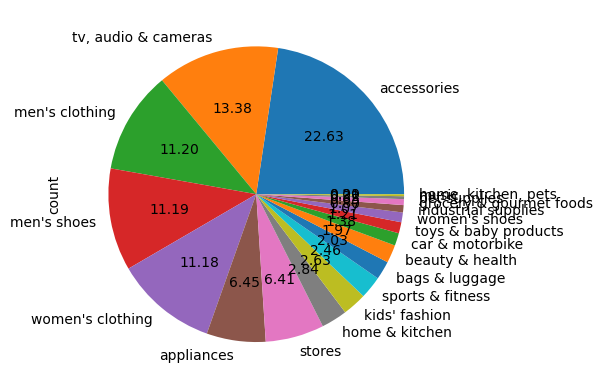

,sub_category,count
0,men's clothing -> Jeans,19200
1,men's clothing -> Shirts,19200
4,men's shoes -> Formal Shoes,19200
5,men's shoes -> Sports Shoes,19200
8,women's clothing -> Western Wear,19200
6,women's clothing -> Clothing,19152
2,men's clothing -> T-shirts & Polos,19104
3,men's shoes -> Casual Shoes,19056
7,women's clothing -> Ethnic Wear,19056


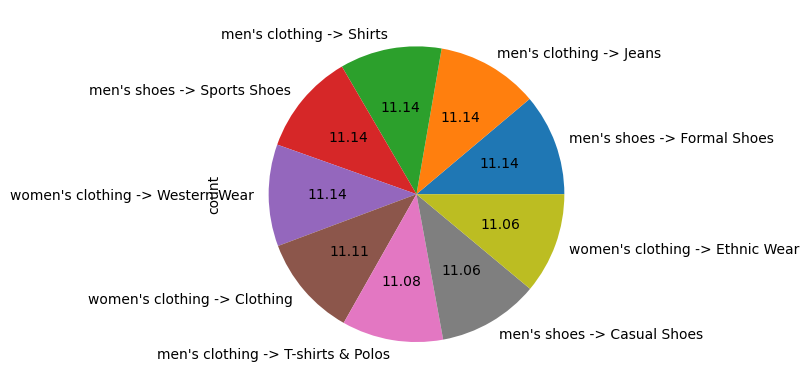

[
  {
    "Unnamed: 0": 1890,
    "name": "Classic Polo Mens Solid Cotton Slim Fit Full Sleeve Woven Shirt",
    "main_category": "men's clothing",
    "sub_category": "men's clothing -> Shirts",
    "image": "https://m.media-amazon.com/images/I/51cHl04IspL._AC_UL320_.jpg",
    "link": "https://www.amazon.in/Classic-Polo-Cotton-Sleeve-X-Large/dp/B09R7YJ98D/ref=sr_1_1899?qid=1679140845&s=apparel&sr=1-1899",
    "ratings": "3.5",
    "no_of_ratings": "9",
    "discount_price": "\u20b91,439",
    "actual_price": "\u20b91,599"
  },
  {
    "Unnamed: 0": 12953,
    "name": "Arrow Men's Slim Fit Shirt",
    "main_category": "men's clothing",
    "sub_category": "men's clothing -> Shirts",
    "image": "https://m.media-amazon.com/images/I/91emoYrKzjL._AC_UL320_.jpg",
    "link": "https://www.amazon.in/Arrow-Mens-Printed-Shirt-AFACSH0673_Medium/dp/B096VL2MT1/ref=sr_1_12962?qid=1679141353&s=apparel&sr=1-12962",
    "ratings": "3.9",
    "no_of_ratings": "28",
    "discount_price": "\u20b91,139"

In [8]:
# amazon dataset

full_pdf = pd.read_csv('../../datasets/shopping/local/AmazonProducts2023/dataset/Amazon-Products.csv')
blocked_words = ['innerwear', 'nightwear']
full_pdf = full_pdf[full_pdf['main_category'].apply(lambda x: not any([re.search(word, x, re.IGNORECASE) for word in blocked_words]))]
full_pdf = full_pdf[full_pdf['sub_category'].apply(lambda x: not any([re.search(word, x, re.IGNORECASE) for word in blocked_words]))]

display(full_pdf.groupby('main_category')[['name']].count().reset_index().rename(columns={'name': 'count'}).sort_values('count', ascending=False).head(10))
full_pdf['main_category'].value_counts().plot.pie(autopct='%.2f')
plt.show()

# keep only clothing and shoes
main_categories = ['men\'s clothing', 'women\'s clothing', 'men\'s shoes']
subcategories_pdf = full_pdf.query('main_category in @main_categories').copy()
subcategories_pdf['sub_category'] = subcategories_pdf['main_category'] + ' -> ' + subcategories_pdf['sub_category']
display(subcategories_pdf.groupby('sub_category')[['name']].count().reset_index().rename(columns={'name': 'count'}).sort_values('count', ascending=False).head(10))
subcategories_pdf['sub_category'].value_counts().plot.pie(autopct='%.2f')
plt.show()

# show random products to get a sense of what the data looks like
print (json.dumps(subcategories_pdf.sample(10).to_dict(orient='records'), indent=2))

# split the dataset into training and testing sets
train_pdf = subcategories_pdf.sample(frac=0.7)
test_pdf = subcategories_pdf.drop(train_pdf.index)
print (f'train_pdf: {train_pdf.shape[0]}, test_pdf: {test_pdf.shape[0]}, full dataset: {subcategories_pdf.shape[0]}')

# save the datasets
train_pdf.to_csv('../../datasets/shopping/local/AmazonProducts2023/train_test_split/clothing_and_shoes_train.csv', index=False)
test_pdf.to_csv('../../datasets/shopping/local/AmazonProducts2023/train_test_split/clothing_and_shoes_test.csv', index=False)

,l1_category,count
43,Clothing,4953
98,Jewellery,3531
73,Footwear,1227
130,Mobiles & Accessories,1099
21,Automotive,1012
86,Home Decor & Festive Needs,929
29,Beauty and Personal Care,710
88,Home Furnishing,700
105,Kitchen & Dining,647
47,Computers,578


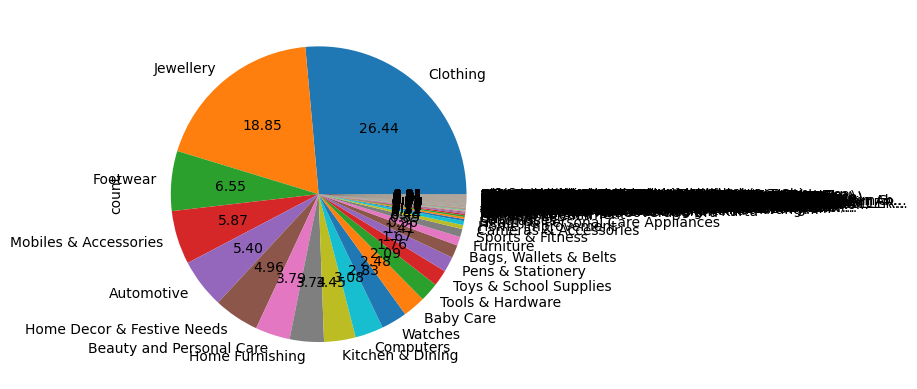

,l2_category,count
4,Clothing >> Women's Clothing,2691
2,Clothing >> Men's Clothing,1771
20,Jewellery >> Necklaces & Chains,1606
10,Footwear >> Women's Footwear,781
24,Jewellery >> Rings,743
14,"Jewellery >> Bangles, Bracelets & Armlets",724
1,Clothing >> Kids' Clothing,487
8,Footwear >> Men's Footwear,340
18,Jewellery >> Jewellery Sets,166
11,Jewellery >> Accessories,114


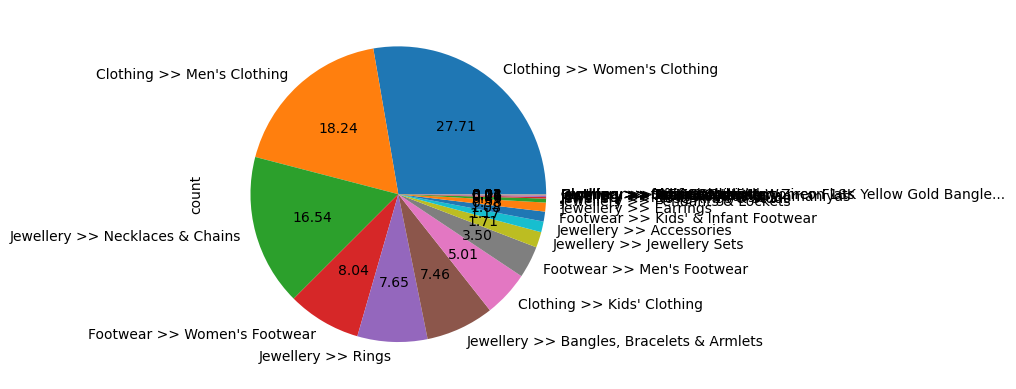

[
  {
    "uniq_id": "4c9e82c8eaa7a09ce54d52661f368c1d",
    "crawl_timestamp": "2015-12-30 00:17:46 +0000",
    "product_url": "http://www.flipkart.com/anasazi-women-s-floral-print-casual-shirt/p/itme7hgfuggchkqu?pid=SHTE7HGFXSVHFHTV",
    "product_name": "Anasazi Women's Floral Print Casual Shirt",
    "product_category_tree": "[\"Clothing >> Women's Clothing >> Western Wear >> Shirts, Tops & Tunics >> Shirts >> Anasazi Shirts\"]",
    "pid": "SHTE7HGFXSVHFHTV",
    "retail_price": 549.0,
    "discounted_price": 247.0,
    "image": "[\"http://img6a.flixcart.com/image/shirt/r/3/w/at-242-anasazi-xxl-original-imae7may5gwdje62.jpeg\", \"http://img5a.flixcart.com/image/shirt/r/3/w/at-242-anasazi-xxl-original-imae7may5gwdje62.jpeg\", \"http://img5a.flixcart.com/image/shirt/r/3/w/at-242-anasazi-xxl-original-imae7mayyu4p9tkg.jpeg\", \"http://img6a.flixcart.com/image/shirt/r/3/w/at-242-anasazi-xxl-original-imae7may5pzg6tzr.jpeg\", \"http://img5a.flixcart.com/image/shirt/r/3/w/at-242-anasazi-x

In [47]:
# flipkart dataset

full_pdf = pd.read_csv('../../datasets/shopping/local/FlipkartEcommerce/flipkart_com-ecommerce_sample.csv')\
    .query('product_category_tree.isnull() == False')
blocked_words = ['innerwear', 'nightwear', 'swimwear', 'lingerie']
full_pdf = full_pdf[full_pdf['product_category_tree'].apply(lambda x: not any([re.search(word, x, re.IGNORECASE) for word in blocked_words]))]

def get_category(category_tree, level):
    try:
        category_tree = json.loads(category_tree)[0]
    except:
        category_tree = None
    if category_tree is None:
        return "UNKNOWN"
    categories = [c.strip() for c in category_tree.split('>>')]
    if len(categories) >= level:
        return " >> ".join(categories[:level])
    else:
        return "UNKNOWN"
    
full_pdf['l1_category'] = full_pdf['product_category_tree'].apply(lambda x: get_category(x, 1))
full_pdf['l2_category'] = full_pdf['product_category_tree'].apply(lambda x: get_category(x, 2))
full_pdf['l3_category'] = full_pdf['product_category_tree'].apply(lambda x: get_category(x, 3))

# show the distribution of l1 categories
display(full_pdf.groupby('l1_category')[['uniq_id']].count().reset_index().rename(columns={'uniq_id': 'count'}).sort_values('count', ascending=False).head(10))
full_pdf['l1_category'].value_counts().plot.pie(autopct='%.2f')
plt.show()

# keep only clothing and footwear categories and show distribution of l2 categories
l1_categories = ['Clothing', 'Footwear', 'Jewellery']
subcategories_pdf = full_pdf.query('l1_category in @l1_categories').copy()
display(subcategories_pdf.groupby('l2_category')[['uniq_id']].count().reset_index().rename(columns={'uniq_id': 'count'}).sort_values('count', ascending=False).head(10))
subcategories_pdf['l2_category'].value_counts().plot.pie(autopct='%.2f')
plt.show()

# show random products to get a sense of what the data looks like
print (json.dumps(subcategories_pdf.sample(3).to_dict(orient='records'), indent=2))

# split the dataset into training and testing sets
train_pdf = subcategories_pdf.sample(frac=0.7)
test_pdf = subcategories_pdf.drop(train_pdf.index)
print (f'train_pdf: {train_pdf.shape[0]}, test_pdf: {test_pdf.shape[0]}, full dataset: {subcategories_pdf.shape[0]}')

# save the datasets
train_pdf.to_csv('../../datasets/shopping/local/FlipkartEcommerce/train_test_split/clothing_and_footwear_train.csv', index=False)
test_pdf.to_csv('../../datasets/shopping/local/FlipkartEcommerce/train_test_split/clothing_and_footwear_test.csv', index=False)

In [176]:
# load the training data for n-gram language model

def load_lm_data(dataset = 'amazon', exclude_description = False, split='train'):
    if dataset == 'amazon':
        pdf = pd.read_csv(f'../../datasets/shopping/local/AmazonProducts2023/train_test_split/clothing_and_shoes_{split}.csv')
        return pdf['name'].tolist()
    elif dataset == 'flipkart':
        pdf = pd.read_csv(f'../../datasets/shopping/local/FlipkartEcommerce/train_test_split/clothing_and_footwear_{split}.csv')
        return [str(row['product_name']) + ('\n\n' + str(row['description']) if not exclude_description else '') for _, row in pdf.iterrows()]
    else:
        raise ValueError(f'Invalid dataset: {dataset}')

In [177]:
# use the same tokenizer throughout the notebook
def tokenize_text(text):
    return word_tokenize(text.lower())

def tokenize_and_pad_text(text):
    tokens = tokenize_text(text)
    padded_tokens = list(pad_sequence(tokens,
        pad_left=True,
        left_pad_symbol="_START_",
        pad_right=True,
        right_pad_symbol="_END_",
        n=2))
    return padded_tokens

In [194]:
# get a dictionary that maps n-grams to their counts
def get_all_ngram_counts(ngram_counts):
    ngram_to_counts = {}
    for n in range(1, 100):
        if n in ngram_counts._counts:
            if n==1:
                for word, value in ngram_counts._counts[n].items():
                    ngram_to_counts[(word,)] = value
            else:
                for context in ngram_counts._counts[n]:
                    for word, value in ngram_counts._counts[n][context].items():
                        ngram_to_counts[tuple(list(context)+[word])] = value
    return ngram_to_counts

In [203]:
"""
total 3 possible datasets: amazon, flipkart (description included), flipkart_no_desc (description excluded)
for each dataset:
1. obtain train and dev 80/20 split   // dev set is used for tuning hyperparameters
2. obtain frozen vocab for each train dataset and save for later use   // all downstream n-gram generation should use this vocab only to obtain comparable perplexity scores
3. obtain n-gram (till 5-grams) counts for each train dataset and save for later use    // unique n-grams will be later looked up into google n-gram corpus to obtain frequency counts from a larger corpus
"""

def split_into_train_dev(data, split_ratio = 0.8, seed = 42):
    random.seed(seed)
    random.shuffle(data)
    split_idx = int(len(data) * split_ratio)
    return data[:split_idx], data[split_idx:]

dataset_to_info = {}
if not os.path.exists('local/datasets_info.pkl'):
    datasets = ['amazon', 'flipkart', 'flipkart_no_desc']
    for dataset in datasets:
        print (f'Processing dataset: {dataset}')
        exclude_description = (dataset == 'flipkart_no_desc')
        dataset_name = dataset.split('_')[0]
        test_data = load_lm_data(dataset_name, exclude_description=exclude_description, split='test')
        train_data = load_lm_data(dataset_name, exclude_description=exclude_description, split='train')
        train_data, dev_data = split_into_train_dev(train_data)
        print (f'train_data: {len(train_data)}, dev_data: {len(dev_data)}, test_data: {len(test_data)}')

        # compute vocab and n-gram counts
        tokenized_and_padded_sentences = [tokenize_and_pad_text(s) for s in train_data]

        vocab = Vocabulary(flatten(tokenized_and_padded_sentences), unk_cutoff=2)
        print (f'Vocab size: {len(vocab)}')

        ngram_counts = NgramCounter()
        for sentence in tqdm(tokenized_and_padded_sentences, desc=f'Counting ngrams in {dataset} train data'):
            ngram_counts.update([everygrams(vocab.lookup(sentence), max_len=5)])
        
        num_unique_ngrams = 0
        for n in range(1, 100):
            if n in ngram_counts._counts:
                if n==1:
                    num_unique_ngrams += len(ngram_counts._counts[n])
                else:
                    for context in ngram_counts._counts[n]:
                        num_unique_ngrams += len(ngram_counts._counts[n][context])
        print (f'Number of unique n-grams: {num_unique_ngrams}')
        print (f"Number of tokens in total: {sum([len(s) for s in tokenized_and_padded_sentences])}")
        print (f"Number of ngrams in total: {ngram_counts.N()}")
        print ("--------------\n")
        
        dataset_to_info[dataset] = {
            'train_data': train_data,
            'dev_data': dev_data,
            'test_data': test_data,
            'vocab': vocab,
            'ngram_counts': ngram_counts
        }
    with open('local/datasets_info.pkl', 'wb') as f:
        pickle.dump(dataset_to_info, f)
else:
    with open('local/datasets_info.pkl', 'rb') as f:
        dataset_to_info = pickle.load(f)

Processing dataset: amazon
train_data: 96526, dev_data: 24132, test_data: 51710
Vocab size: 18309


Counting ngrams in amazon train data:   0%|          | 0/96526 [00:00<?, ?it/s]

Number of unique n-grams: 1198154
Number of tokens in total: 1226907
Number of ngrams in total: 5169384
--------------

Processing dataset: flipkart
train_data: 5438, dev_data: 1360, test_data: 2913
Vocab size: 7663


Counting ngrams in flipkart train data:   0%|          | 0/5438 [00:00<?, ?it/s]

Number of unique n-grams: 357615
Number of tokens in total: 398600
Number of ngrams in total: 1938620
--------------

Processing dataset: flipkart_no_desc
train_data: 5438, dev_data: 1360, test_data: 2913
Vocab size: 1586


Counting ngrams in flipkart_no_desc train data:   0%|          | 0/5438 [00:00<?, ?it/s]

Number of unique n-grams: 36609
Number of tokens in total: 45453
Number of ngrams in total: 172887
--------------



In [327]:
def get_ngram_count_subset(ngram_counts, n):
    # returns a shallow copy of ngram_counts where only n_grams of size <= n are kept
    assert n >= 1
    reduced_ngram_counts = NgramCounter()
    reduced_ngram_counts.unigrams = ngram_counts.unigrams
    reduced_ngram_counts._counts[1] = ngram_counts._counts[1]
    for i in range(2, n+1):
        if i in ngram_counts._counts:
            reduced_ngram_counts._counts[i] = ngram_counts._counts[i]
    return reduced_ngram_counts

In [433]:
def build_model(model_config):
    dataset = model_config['dataset']
    dataset_info = dataset_to_info[dataset]
    model_type = model_config['model_type']
    order = model_config['order']
    vocab = dataset_info['vocab']
    ngram_counts = dataset_info['ngram_counts']
    model = None
    if model_type == "Lidstone":
        gamma = model_config['gamma']
        model = lm.Lidstone(gamma, order, vocabulary=vocab, counter=get_ngram_count_subset(ngram_counts, order))
    elif model_type == "WittenBell":
        model = lm.WittenBellInterpolated(order, vocabulary=vocab, counter=get_ngram_count_subset(ngram_counts, order))
    elif model_type == "AbsoluteDiscounting":
        discount = model_config['discount']
        model = lm.AbsoluteDiscountingInterpolated(order, discount=discount, vocabulary=vocab, counter=get_ngram_count_subset(ngram_counts, order))
    else:
        raise ValueError(f'Invalid model_type: {model_type}. Must be one of Lidstone, WittenBell, AbsoluteDiscounting')
    return model

In [434]:
"""
Tune hyperparametrs by evaluating entropy on a sample of dev set. 
Optimize by using only necessary samples for evaluation. Stop when entropy 
is stabilized and the relative ranking of models is not changing by evaluating on 
more samples anymore
"""
def get_eval_ngrams(sentences, vocab, order, seed=42):
    eval_ngrams = []
    sentences = copy.deepcopy(sentences)
    random.seed(seed)
    random.shuffle(sentences)
    for sentence in sentences:
        tokens = vocab.lookup(tokenize_and_pad_text(sentence))
        sentence_ngrams = []
        for i in range(1, len(tokens)):
            sentence_ngrams.append(tokens[max(0, i-order+1):i+1])
        eval_ngrams.append(sentence_ngrams)
    return eval_ngrams
            

In [435]:
def update_status_based_on_ranking(model_name_to_data, model_rankings, lookback=20):
    # deactivate models whose relative ranking with other models has not changed in the last lookback iterations
    if len(model_rankings) < lookback:
        return
    active_models = set([m for m in model_name_to_data if model_name_to_data[m]['status']=='ACTIVE'])
    active_models_rankings = [[r[0] for r in ranking if r[0] in active_models] for ranking in model_rankings[-lookback:]]
    for model_name in active_models:
        ranking_changed = False
        for ranking_idx in range(1, len(active_models_rankings)):
            curr_ranking = active_models_rankings[ranking_idx]
            curr_better_models = set(curr_ranking[:curr_ranking.index(model_name)])
            prev_ranking = active_models_rankings[ranking_idx-1]
            prev_better_models = set(prev_ranking[:prev_ranking.index(model_name)])
            if curr_better_models != prev_better_models:
                ranking_changed = True
                break
        if not ranking_changed:
            model_name_to_data[model_name]['status'] = 'INACTIVE'
    return

In [436]:
def plot_perplexities(model_name_to_data, model_rankings):
    clear_output(wait=True)
    # show current rankings
    print ("Current rankings:")
    model_to_rank = {}
    for rank, (model_name, entropy) in enumerate(model_rankings[-1]):
        print (f'{rank+1}. {model_name}: {pow(2, entropy)}')
        model_to_rank[model_name] = rank+1
    # plot perplexities
    pdf = []
    for model_name, data in model_name_to_data.items():
        for idx, perplexity in enumerate(data['perplexities']):
            rank = model_to_rank[model_name]
            pdf.append({
                'model': f"[{rank}] {model_name}",
                'rank': rank,
                'perplexity': perplexity,
                'sample_size': idx * 100
            })
    pdf = pd.DataFrame(pdf).sort_values(by=['sample_size', 'rank'])
    # Temporarily ignore FutureWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        sns.lineplot(data=pdf, x='sample_size', y='perplexity', hue='model')
    # Set the y-axis to logarithmic scale
    plt.yscale('log')
    # move legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # make plot big and wide
    plt.gcf().set_size_inches(20, 10)
    plt.show()

In [437]:
def evaluate_models(model_configs, lookback=20):
    # there should be only one dataset
    assert len(set([model_config['dataset'] for model_config in model_configs])) == 1
    dataset = model_configs[0]['dataset']
    vocab = dataset_to_info[dataset]['vocab']
    dev_sentences = dataset_to_info[dataset]['dev_data']

    order_to_eval_ngrams = {}
    for order in tqdm(range(1, 6), desc='Generating eval ngrams'):
        order_to_eval_ngrams[order] = get_eval_ngrams(dev_sentences, vocab, order)

    model_name_to_data = {}
    for model_config in model_configs:
        model_name = model_config['model_name']
        model = build_model(model_config)
        model_name_to_data[model_name] = {
            'model': model,
            'config': model_config,
            'status': 'ACTIVE',
            'entropies': [],
            'perplexities': []
        }
    model_rankings = []
    last_plot_time = time.time()
    for i in range(len(dev_sentences)):
        for model_name, model_data in model_name_to_data.items():
            if model_data['status'] == 'ACTIVE':
                for ngram in order_to_eval_ngrams[model_data['config']['order']][i]:
                    model_data['entropies'].append(
                        -1 * model_data['model'].logscore(ngram[-1], tuple(ngram[:-1]))
                    )
        if (i+1) % 100 == 0:
            average_entropies = []
            for model_name, model_data in model_name_to_data.items():
                average_entropy = sum(model_data['entropies']) / len(model_data['entropies'])
                model_data['perplexities'].append(pow(2, average_entropy))
                average_entropies.append((model_name, average_entropy))
            model_rankings.append(sorted(average_entropies, key=lambda x: x[1]))
            update_status_based_on_ranking(model_name_to_data, model_rankings, lookback=lookback)
            if time.time() - last_plot_time > 5:
                plot_perplexities(model_name_to_data, model_rankings)
                last_plot_time = time.time()
    return model_name_to_data, model_rankings        

Current rankings:
1. WittenBell_5: 11.863027499511034
2. AbsoluteDiscounting_5_0.75: 12.169272831294155
3. AbsoluteDiscounting_5_0.5: 12.673862284390038
4. WittenBell_4: 13.100211453249585
5. AbsoluteDiscounting_4_0.75: 13.497458856908363
6. AbsoluteDiscounting_4_0.5: 13.774570929903208
7. AbsoluteDiscounting_5_0.99: 14.615084104671162
8. AbsoluteDiscounting_4_0.99: 16.007042275468052
9. WittenBell_3: 17.422267137368056
10. AbsoluteDiscounting_3_0.75: 17.68681255366288
11. AbsoluteDiscounting_3_0.5: 17.7334116856771
12. AbsoluteDiscounting_4_0.1: 18.19814034131281
13. AbsoluteDiscounting_5_0.1: 18.282401566072352
14. AbsoluteDiscounting_3_0.99: 20.34807525002984
15. AbsoluteDiscounting_3_0.1: 21.374483990107336
16. AbsoluteDiscounting_3_0.01: 28.90135151325716
17. AbsoluteDiscounting_4_0.01: 29.578325499432697
18. Lidstone_3_0.0001: 30.41867824717392
19. AbsoluteDiscounting_2_0.5: 34.7515214485267
20. AbsoluteDiscounting_5_0.01: 34.762081651318006
21. Lidstone_3_1e-05: 34.7877565676815

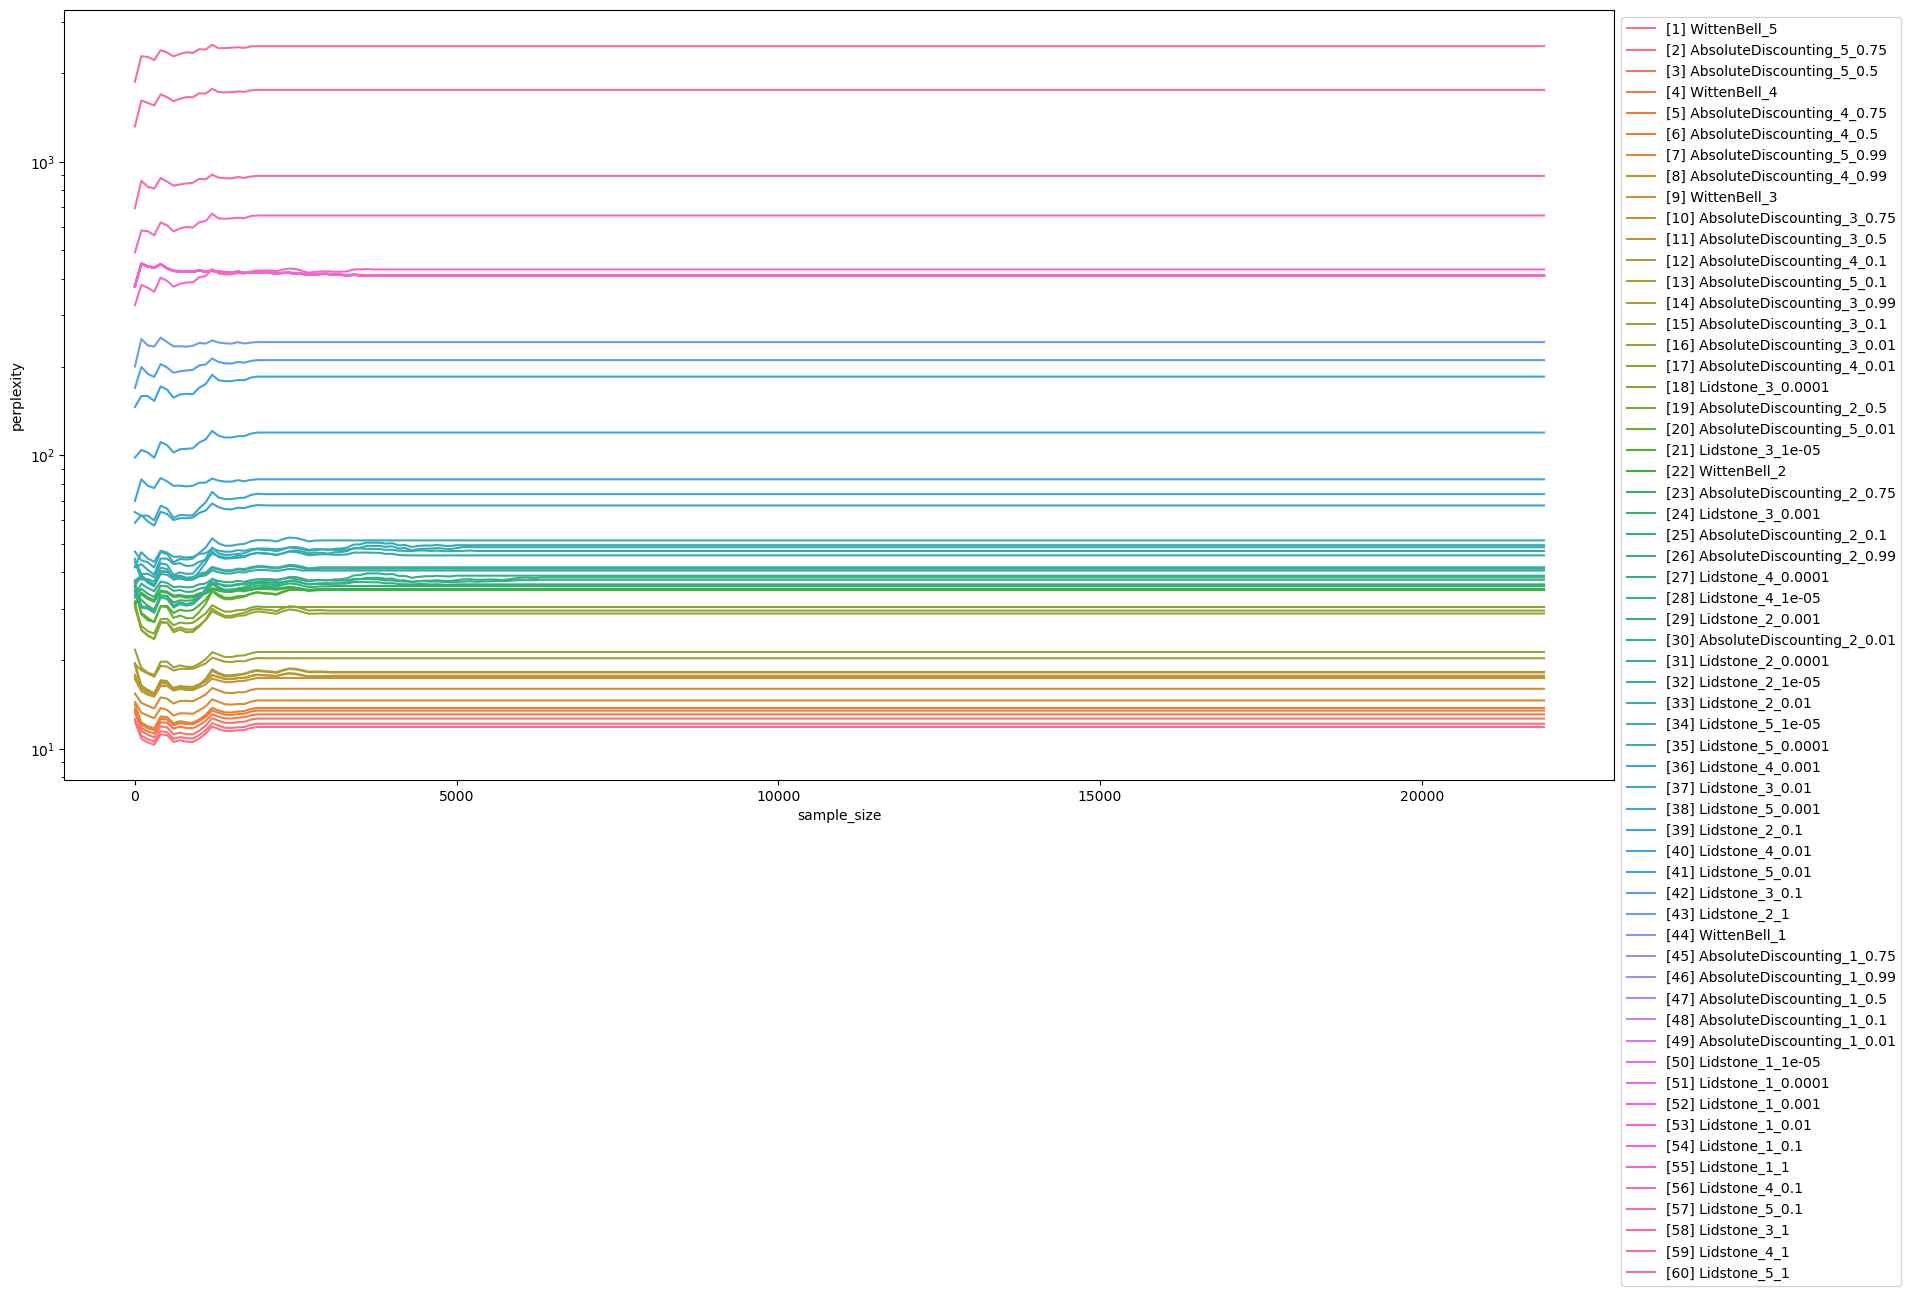

In [440]:
# tune hyperparams for amazon dataset
model_configs = []
for n in range(1, 6):
    for gamma in [1, 0.1, 0.01, 0.001, 0.0001, 1e-5]:
        model_configs.append({
            'dataset': 'amazon',
            'model_name': f'Lidstone_{n}_{gamma}',
            'model_type': 'Lidstone',
            'order': n,
            'gamma': gamma
        })
    model_configs.append({
        'dataset': 'amazon',
        'model_name': f'WittenBell_{n}',
        'model_type': 'WittenBell',
        'order': n
    })
    for discount in [0.75, 0.99, 0.5, 0.1, 0.01]:
        model_configs.append({
            'dataset': 'amazon',
            'model_name': f'AbsoluteDiscounting_{n}_{discount}',
            'model_type': 'AbsoluteDiscounting',
            'order': n,
            'discount': discount
        })
model_name_to_data, model_rankings = evaluate_models(model_configs)

In [441]:
# interpolated models are able to utilize the context better and hence have lower perplexities
# default discounting value of 0.75 for AbsoluteDiscounting seems to work well
# lidstone requires very low gamma. Perplexities are quite high for gamma=1
amazon_model_rankings = copy.deepcopy(model_rankings)
amazon_model_rankings[-1]

[('WittenBell_5', 3.5684003342103474),
 ('AbsoluteDiscounting_5_0.75', 3.6051710580064737),
 ('AbsoluteDiscounting_5_0.5', 3.6637843391307063),
 ('WittenBell_4', 3.71151819368005),
 ('AbsoluteDiscounting_4_0.75', 3.7546159140435087),
 ('AbsoluteDiscounting_4_0.5', 3.783935475248822),
 ('AbsoluteDiscounting_5_0.99', 3.8693862262580043),
 ('AbsoluteDiscounting_4_0.99', 4.000634851291215),
 ('WittenBell_3', 4.122860467102955),
 ('AbsoluteDiscounting_3_0.75', 4.144602169633566),
 ('AbsoluteDiscounting_3_0.5', 4.148398214232224),
 ('AbsoluteDiscounting_4_0.1', 4.185719124572641),
 ('AbsoluteDiscounting_5_0.1', 4.192383689347385),
 ('AbsoluteDiscounting_3_0.99', 4.346820429498563),
 ('AbsoluteDiscounting_3_0.1', 4.417817686633309),
 ('AbsoluteDiscounting_3_0.01', 4.8530650539068585),
 ('AbsoluteDiscounting_4_0.01', 4.886468475179479),
 ('Lidstone_3_0.0001', 4.926885561306909),
 ('AbsoluteDiscounting_2_0.5', 5.119004236412562),
 ('AbsoluteDiscounting_5_0.01', 5.11944257226729),
 ('Lidstone_3_

Current rankings:
1. AbsoluteDiscounting_5_0.85: 7.375040285296854
2. WittenBell_5: 7.398921961125023
3. AbsoluteDiscounting_5_0.8: 7.412420374722806
4. AbsoluteDiscounting_5_0.75: 7.47654986667065
5. AbsoluteDiscounting_5_0.7: 7.563562486048747
6. WittenBell_4: 7.7348537608703785
7. AbsoluteDiscounting_4_0.85: 7.77386299169611
8. AbsoluteDiscounting_4_0.8: 7.794431543300727
9. AbsoluteDiscounting_5_0.6: 7.8038824713179915
10. AbsoluteDiscounting_4_0.75: 7.8397733212526495
11. AbsoluteDiscounting_4_0.7: 7.906065978043581
12. AbsoluteDiscounting_4_0.6: 8.098399390779496
13. WittenBell_3: 9.179117643748372
14. AbsoluteDiscounting_3_0.8: 9.280934900491793
15. AbsoluteDiscounting_3_0.85: 9.286133468316383
16. AbsoluteDiscounting_3_0.75: 9.299297296866357
17. AbsoluteDiscounting_3_0.7: 9.33714317629304
18. AbsoluteDiscounting_3_0.6: 9.466747809245895
19. Lidstone_3_0.0001: 17.761937592823998
20. Lidstone_3_0.001: 18.116077879436304
21. Lidstone_4_0.0001: 19.445169908560786
22. Lidstone_4_1e

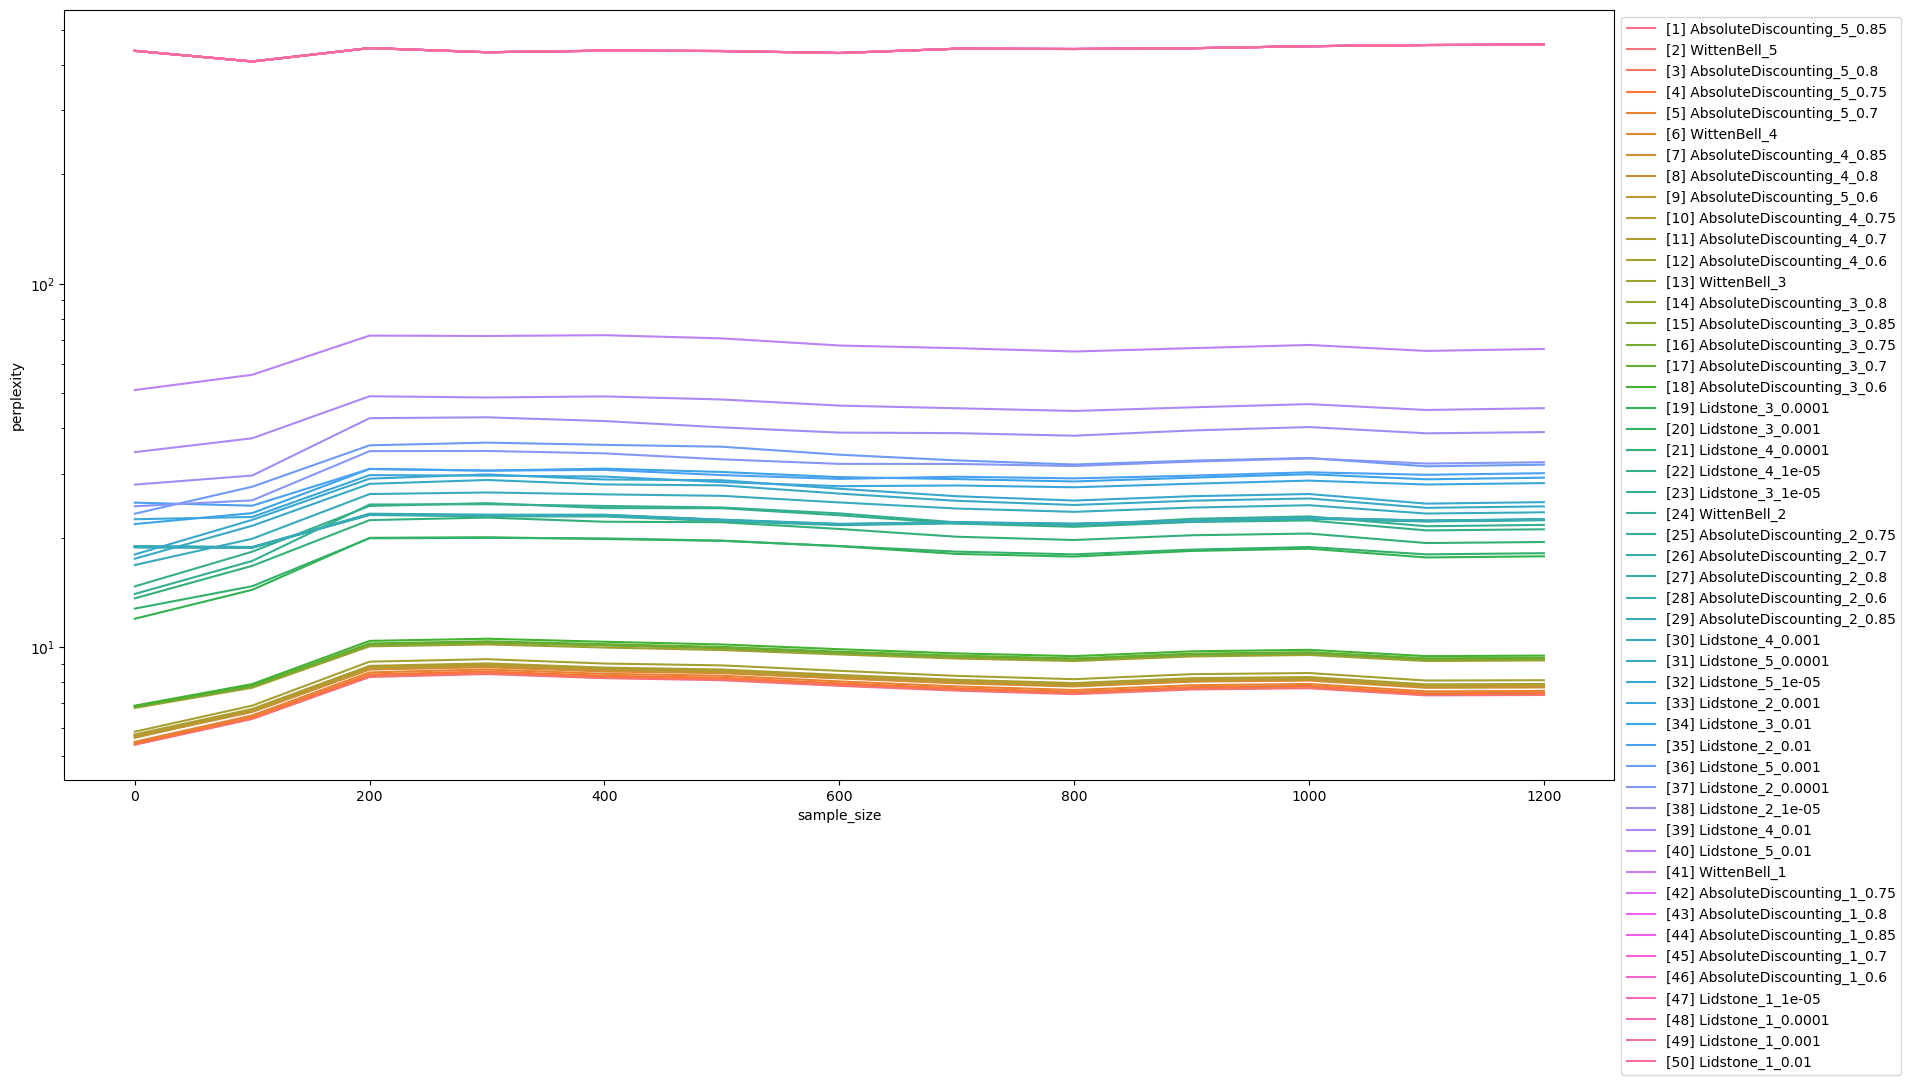

In [438]:
# tune hyperparams for flipkart dataset
model_configs = []
for n in range(1, 6):
    # remove larger gamma values as they will probably not work well
    for gamma in [0.01, 0.001, 0.0001, 1e-5]:
        model_configs.append({
            'dataset': 'flipkart',
            'model_name': f'Lidstone_{n}_{gamma}',
            'model_type': 'Lidstone',
            'order': n,
            'gamma': gamma
        })
    model_configs.append({
        'dataset': 'flipkart',
        'model_name': f'WittenBell_{n}',
        'model_type': 'WittenBell',
        'order': n
    })
    # vary discount close to 0.75 only
    for discount in [0.75, 0.8, 0.85, 0.7, 0.6]:
        model_configs.append({
            'dataset': 'flipkart',
            'model_name': f'AbsoluteDiscounting_{n}_{discount}',
            'model_type': 'AbsoluteDiscounting',
            'order': n,
            'discount': discount
        })
model_name_to_data, model_rankings = evaluate_models(model_configs)

In [439]:
flipkart_model_rankings = copy.deepcopy(model_rankings)
flipkart_model_rankings[-1]

[('AbsoluteDiscounting_5_0.85', 2.8826509299366556),
 ('WittenBell_5', 2.8873150822770963),
 ('AbsoluteDiscounting_5_0.8', 2.8899447021059212),
 ('AbsoluteDiscounting_5_0.75', 2.9023726767270954),
 ('AbsoluteDiscounting_5_0.7', 2.9190659130677794),
 ('WittenBell_4', 2.951374015596546),
 ('AbsoluteDiscounting_4_0.85', 2.9586316815203846),
 ('AbsoluteDiscounting_4_0.8', 2.9624438093802716),
 ('AbsoluteDiscounting_5_0.6', 2.964192050714304),
 ('AbsoluteDiscounting_4_0.75', 2.9708119409434848),
 ('AbsoluteDiscounting_4_0.7', 2.982959994848787),
 ('AbsoluteDiscounting_4_0.6', 3.0176367945194884),
 ('WittenBell_3', 3.1983554791107967),
 ('AbsoluteDiscounting_3_0.8', 3.2142701403062435),
 ('AbsoluteDiscounting_3_0.85', 3.2150780167105597),
 ('AbsoluteDiscounting_3_0.75', 3.2171217028197403),
 ('AbsoluteDiscounting_3_0.7', 3.2229812056256963),
 ('AbsoluteDiscounting_3_0.6', 3.242868889758307),
 ('Lidstone_3_0.0001', 4.150717064136457),
 ('Lidstone_3_0.001', 4.179198741421312),
 ('Lidstone_4_0.

Current rankings:
1. WittenBell_5: 6.669518887052616
2. AbsoluteDiscounting_5_0.75: 6.69342720899458
3. AbsoluteDiscounting_5_0.7: 6.701004458798113
4. AbsoluteDiscounting_5_0.8: 6.70775254451243
5. AbsoluteDiscounting_5_0.85: 6.7511477363443095
6. AbsoluteDiscounting_5_0.6: 6.770179527523603
7. WittenBell_4: 6.799437987162045
8. AbsoluteDiscounting_4_0.7: 6.853106880565675
9. AbsoluteDiscounting_4_0.75: 6.860112894469372
10. AbsoluteDiscounting_4_0.8: 6.88753959528545
11. AbsoluteDiscounting_4_0.6: 6.888488299430893
12. AbsoluteDiscounting_4_0.85: 6.94237778368714
13. WittenBell_3: 7.460384102141443
14. AbsoluteDiscounting_3_0.6: 7.5149739206391715
15. AbsoluteDiscounting_3_0.7: 7.5277790396730175
16. AbsoluteDiscounting_3_0.75: 7.555238396143436
17. AbsoluteDiscounting_3_0.8: 7.6006280323513655
18. AbsoluteDiscounting_3_0.85: 7.6704773466387675
19. AbsoluteDiscounting_2_0.6: 9.916040097815864
20. AbsoluteDiscounting_2_0.7: 10.008926452376729
21. WittenBell_2: 10.035392890766524
22. A

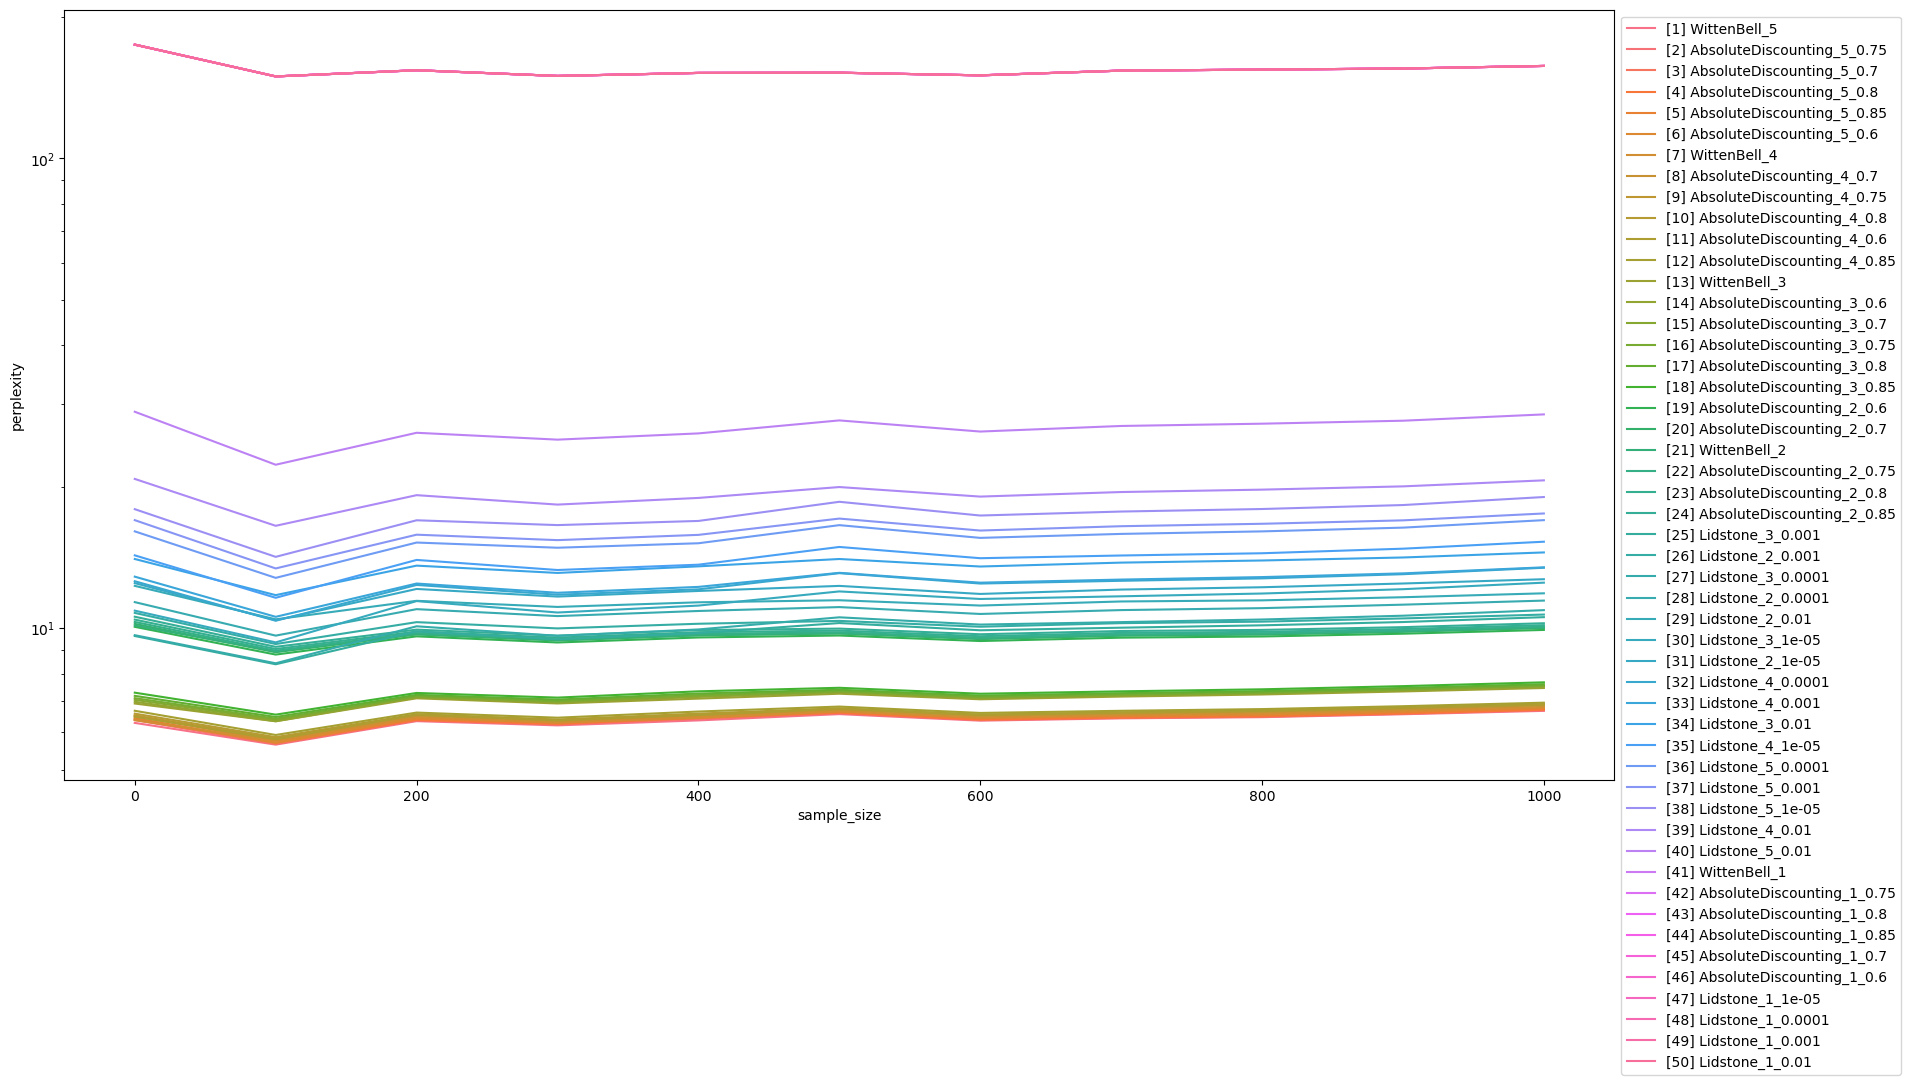

In [442]:
# tune hyperparams for flipkart_no_desc dataset
model_configs = []
for n in range(1, 6):
    # remove larger gamma values as they will probably not work well
    for gamma in [0.01, 0.001, 0.0001, 1e-5]:
        model_configs.append({
            'dataset': 'flipkart_no_desc',
            'model_name': f'Lidstone_{n}_{gamma}',
            'model_type': 'Lidstone',
            'order': n,
            'gamma': gamma
        })
    model_configs.append({
        'dataset': 'flipkart_no_desc',
        'model_name': f'WittenBell_{n}',
        'model_type': 'WittenBell',
        'order': n
    })
    # vary discount close to 0.75 only
    for discount in [0.75, 0.8, 0.85, 0.7, 0.6]:
        model_configs.append({
            'dataset': 'flipkart_no_desc',
            'model_name': f'AbsoluteDiscounting_{n}_{discount}',
            'model_type': 'AbsoluteDiscounting',
            'order': n,
            'discount': discount
        })
model_name_to_data, model_rankings = evaluate_models(model_configs)

In [443]:
flipkart_no_desc_model_rankings = copy.deepcopy(model_rankings)
flipkart_no_desc_model_rankings[-1]

[('WittenBell_5', 2.704106377612263),
 ('AbsoluteDiscounting_5_0.75', 2.709280483521151),
 ('AbsoluteDiscounting_5_0.7', 2.710741288573072),
 ('AbsoluteDiscounting_5_0.8', 2.712435557404679),
 ('AbsoluteDiscounting_5_0.85', 2.721676187023621),
 ('AbsoluteDiscounting_5_0.6', 2.724968906421967),
 ('WittenBell_4', 2.7328811263567157),
 ('AbsoluteDiscounting_4_0.7', 2.7435629377434347),
 ('AbsoluteDiscounting_4_0.75', 2.7452046338937013),
 ('AbsoluteDiscounting_4_0.6', 2.750423638566036),
 ('AbsoluteDiscounting_4_0.8', 2.751033011266547),
 ('AbsoluteDiscounting_4_0.85', 2.7624201338729852),
 ('WittenBell_3', 2.873399278603197),
 ('AbsoluteDiscounting_3_0.6', 2.882407934056069),
 ('AbsoluteDiscounting_3_0.7', 2.885209013219899),
 ('AbsoluteDiscounting_3_0.75', 2.890551143814252),
 ('AbsoluteDiscounting_3_0.8', 2.8992119903865436),
 ('AbsoluteDiscounting_3_0.85', 2.9123368790391058),
 ('AbsoluteDiscounting_2_0.6', 3.2959611789223784),
 ('AbsoluteDiscounting_2_0.7', 3.3093747105956823),
 ('Wi

In [458]:
"""
similar observations across datsets
entropy of best model is higher in amazon dataset compared to flipkart datasets
does it means that flipkart dataset is more simple / predictable?

Samples from amazon:

Amazon Brand - Symbol Men's Color Block Regular T-Shirt (SS20SYMTEE13_Iris Navy XL)
Women's 100% Cotton Plain Regular Fit Round Neck Half Sleeve Tshirt
XL LOVE - By Janasya Women's Plus Size Mustard Rayon Kurta with Pant and Dupatta

Samples from flipkart (no descriptions):

Oviyon Solid Men's Polo Neck T-Shirt
Jayanti sarees Party Embroidered Women's Kurti
Design Desk Self Design Girl's Lehenga, Choli and Dupatta Set
Inmark Men's Striped Formal Shirt

Amazon titles probably have more tail words due to various brands, more detailed specs like color, size, etc., 
noise like product ids, parenthesis: "(SS20SYMTEE13_Iris Navy XL)

Flipkart titles are cleaner and less information dense. 

flipkart_no_desc and flipkart datasets have similar perplexities. I would've expected flipkart with descriptions to
be lower because it has more grammatically determined filler worlds like on, the, etc. Little gap between the two
probably menas that it didn't learn much grammar from the descriptions and most of the learning is simply memorization
"""
_=1

In [446]:
# are lower perplexity models able to generate more coherent text?
# TODO: try different sampling techniques like beam search, nucleus sampling, etc.

In [455]:
# amazon dataset

print ("Some sample sentences from actual dataset\n\n")
dev_data = dataset_to_info['amazon']['dev_data']
vocab = dataset_to_info['amazon']['vocab']
# sample 10 random sentences
for sentence in random.sample(dev_data, 10):
    print (sentence, " -> ", vocab.lookup(tokenize_and_pad_text(sentence)))

print ('-'*50)

model_configs = []

# some good models
for n in range(1, 6):
    model_configs.append({ 
        'dataset': 'amazon',
        'model_name': f'WittenBell_{n}',
        'model_type': 'WittenBell',
        'order': n
    })

model_configs.append({ 
        'dataset': 'amazon',
        'model_name': 'AbsoluteDiscounting_3_0.75',
        'model_type': 'AbsoluteDiscounting',
        'order': 3,
        'discount': 0.75
    })

# some bad models
model_configs.append({ 
        'dataset': 'amazon',
        'model_name': 'Lidstone_2_1',
        'model_type': 'Lidstone',
        'order': 2,
        'gamma': 1
    })

model_configs.append({ 
        'dataset': 'amazon',
        'model_name': 'AbsoluteDiscounting_2_0.01',
        'model_type': 'AbsoluteDiscounting',
        'order': 2,
        'discount': 0.01
    })

# best lidstone
model_configs.append({ 
        'dataset': 'amazon',
        'model_name': 'Lidstone_3_0.0001',
        'model_type': 'Lidstone',
        'order': 3,
        'gamma': 0.0001
    })

for config in model_configs:
    model = build_model(config)
    print (f"\n\nModel: {config['model_name']}")
    for i in range(10):
        context = ['_START_']
        for _ in range(20):
            next_word = model.generate(text_seed=context)
            context.append(next_word)
            if next_word == '_END_':
                break
        print (f"Sample-{i}: ", (' '.join(context)))
    print ('-'*50)

Some sample sentences from actual dataset


Amazon Brand - Symbol Men's Color Block Regular T-Shirt (SS20SYMTEE13_Iris Navy XL)  ->  ('_START_', 'amazon', 'brand', '-', 'symbol', 'men', "'s", 'color', 'block', 'regular', 't-shirt', '(', '<UNK>', 'navy', 'xl', ')', '_END_')
XL LOVE - By Janasya Women's Plus Size Mustard Rayon Kurta with Pant and Dupatta  ->  ('_START_', 'xl', 'love', '-', 'by', 'janasya', 'women', "'s", 'plus', 'size', 'mustard', 'rayon', 'kurta', 'with', 'pant', 'and', 'dupatta', '_END_')
POPWINGS Formal Casual Black Solid Highrise Women Trouser  ->  ('_START_', 'popwings', 'formal', 'casual', 'black', 'solid', 'highrise', 'women', 'trouser', '_END_')
Studio Shringaar Women's Polyester Silk Sleeveless Saree Blouse  ->  ('_START_', 'studio', 'shringaar', 'women', "'s", 'polyester', 'silk', 'sleeveless', 'saree', 'blouse', '_END_')
Women's 100% Cotton Plain Regular Fit Round Neck Half Sleeve Tshirt  ->  ('_START_', 'women', "'s", '100', '%', 'cotton', 'plain', 'regular',

In [456]:
"""
Observations:

order 3-4 are more coherent than order 1 and 2. But probably due to memorization of training data

Lidstone_2_1 (perplexity=243) and Lidstone_3_0.0001 (perplexity=30) both have comparable and similar looking text samples. Even though there is big gap in perplexity scores

Long range dependencies are clearly not captured by 2-3 order models.
AbsoluteDiscounting_2_0.01
    lee men 's slim fit & motherhood maternity feeding kurti women silk jacquard blouse piece
    jack & maxi long sleeve premium tank top combo

On the other hand, the dataset is simple enough that decent order 4-5 models are able to maintain coherence end-to-end in most samples.
WittenBell_5
    bond street by redtape men 's sneakers
    united colors of benetton regular collar lyocell floral print slim fit shirt

WittenBell_4
    pakiza women 's cotton printed plus size cotton regular fit solid cotton blue t-shirt ( mtsh00037-blue )
"""
_=1

In [460]:
# flipkart dataset

print ("Some sample sentences from actual dataset\n\n")
dev_data = dataset_to_info['flipkart']['dev_data']
vocab = dataset_to_info['flipkart']['vocab']
# sample 10 random sentences
for sentence in random.sample(dev_data, 10):
    print (sentence.replace('\n', '\\n'), "\n\n")

print ('-'*50)

model_configs = []

# some good models
for n in range(1, 6):
    model_configs.append({ 
        'dataset': 'flipkart',
        'model_name': f'WittenBell_{n}',
        'model_type': 'WittenBell',
        'order': n
    })

model_configs.append({ 
        'dataset': 'flipkart',
        'model_name': 'AbsoluteDiscounting_3_0.75',
        'model_type': 'AbsoluteDiscounting',
        'order': 3,
        'discount': 0.75
    })

# some bad models
model_configs.append({ 
        'dataset': 'flipkart',
        'model_name': 'Lidstone_2_1',
        'model_type': 'Lidstone',
        'order': 2,
        'gamma': 1
    })

model_configs.append({ 
        'dataset': 'flipkart',
        'model_name': 'AbsoluteDiscounting_2_0.01',
        'model_type': 'AbsoluteDiscounting',
        'order': 2,
        'discount': 0.01
    })

# best lidstone
model_configs.append({ 
        'dataset': 'flipkart',
        'model_name': 'Lidstone_3_0.0001',
        'model_type': 'Lidstone',
        'order': 3,
        'gamma': 0.0001
    })

for config in model_configs:
    model = build_model(config)
    print (f"\n\nModel: {config['model_name']}")
    for i in range(10):
        context = ['_START_']
        for _ in range(20):
            next_word = model.generate(text_seed=context)
            context.append(next_word)
            if next_word == '_END_':
                break
        print (f"Sample-{i}: ", (' '.join(context)))
    print ('-'*50)

Some sample sentences from actual dataset


Shoprillo Women's Solid Formal Shirt\n\nKey Features of Shoprillo Women's Solid Formal Shirt Cotton Formal & Corporate Wear Shirts For Women'S & Girls. Super Fine Quality & Symbol Of Modern Life Style,Shoprillo Women's Solid Formal Shirt (Pack of 2) Price: Rs. 895 Our corporate wear provides best comfort level and enhances the personality of individual wearing it. Best design, best fabric and unique colors are the features of our corporate wear shirts, we offer the customers. Product color may slightly vary due to photographic lighting sources or your monitor settings..,Specifications of Shoprillo Women's Solid Formal Shirt (Pack of 2) General Details Pattern Solid Ideal For Women's Occasion Formal Shirt Details Pleats N/A Sleeve 3/4 Sleeve Closure Button Number of Contents in Sales Package Pack of 2 Brand Fit Regular Fit Fabric Cotton Blend Collar Regular Collar Pockets N/A Fit Regular Placket N/A Hem Curved Hem In the Box 2 Shirts Additiona

In [462]:
# flipkart dataset

print ("Some sample sentences from actual dataset\n\n")
dev_data = dataset_to_info['flipkart_no_desc']['dev_data']
vocab = dataset_to_info['flipkart_no_desc']['vocab']
# sample 10 random sentences
for sentence in random.sample(dev_data, 10):
    print (sentence.replace('\n', '\\n'))

print ('-'*50)

model_configs = []

# some good models
for n in range(1, 6):
    model_configs.append({ 
        'dataset': 'flipkart_no_desc',
        'model_name': f'WittenBell_{n}',
        'model_type': 'WittenBell',
        'order': n
    })

model_configs.append({ 
        'dataset': 'flipkart_no_desc',
        'model_name': 'AbsoluteDiscounting_3_0.75',
        'model_type': 'AbsoluteDiscounting',
        'order': 3,
        'discount': 0.75
    })

# some bad models
model_configs.append({ 
        'dataset': 'flipkart_no_desc',
        'model_name': 'Lidstone_2_1',
        'model_type': 'Lidstone',
        'order': 2,
        'gamma': 1
    })

model_configs.append({ 
        'dataset': 'flipkart_no_desc',
        'model_name': 'AbsoluteDiscounting_2_0.01',
        'model_type': 'AbsoluteDiscounting',
        'order': 2,
        'discount': 0.01
    })

# best lidstone
model_configs.append({ 
        'dataset': 'flipkart_no_desc',
        'model_name': 'Lidstone_3_0.0001',
        'model_type': 'Lidstone',
        'order': 3,
        'gamma': 0.0001
    })

for config in model_configs:
    model = build_model(config)
    print (f"\n\nModel: {config['model_name']}")
    for i in range(10):
        context = ['_START_']
        for _ in range(20):
            next_word = model.generate(text_seed=context)
            context.append(next_word)
            if next_word == '_END_':
                break
        print (f"Sample-{i}: ", (' '.join(context)))
    print ('-'*50)

Some sample sentences from actual dataset


Fashion Jewellery Mother of Pearl Necklace
Karatcraft Bibiana Gold Diamond 18 K Ring
Whistle Solid Men's Round Neck T-Shirt
Oviyon Solid Men's Polo Neck T-Shirt
Jayanti sarees Party Embroidered Women's Kurti
Design Desk Self Design Girl's Lehenga, Choli and Dupatta Set
Inmark Men's Striped Formal Shirt
Mod-Inn Women Wedges
Allen Solly Casual Short Sleeve Solid Women's Top
Glitz Crystal Alloy Necklace
--------------------------------------------------


Model: WittenBell_1
Sample-0:  _START_ hugme.fashion imagine fashion necklace printed _END_


Sample-1:  _START_ bunch 's jeans nirosha neck women material gold mactree round urban orchid , golden nak sleeveless drop _END_
Sample-2:  _START_ _START_ _START_ taj _START_ indsights 's spencer neck _END_
Sample-3:  _START_ <UNK> _END_
Sample-4:  _START_ women shirt _END_
Sample-5:  _START_ length _START_ brass jewelry metal _END_
Sample-6:  _START_ _START_ swarovski _END_
Sample-7:  _START_ _START_ women nimya tie <UNK> _START_ casual yellow _END_
Sample-8:  _START_ printed _END_
Sample-9:  _START_ skirts graphic dress necklace pearl boy 's dress shoes 's _START_ material 's <UNK> _START_ maxi personality green radiant mini
--------------------------------------------------


Model: WittenBell_2
Sample-0:  _START_ <UNK> women 's kurti _END_
Sample-1:  _START_ shop india store women 's leggings _END_
Sample-2:  _START_ manirathnum smoky quartz stone necklace _END_
Sample-3:  _START_ naisha women 's leggings _END_
Sample-4:  _START_ hawai rings fashion brass necklace _END_
Sample-5: 

In [463]:
# TODO: try various sampling techniques like beam search, nucleus sampling, predict randomly dropped words in dev set using the n-gram model

In [2]:
import requests
import json

# The URL to which the request is sent
url = 'https://api.ngrams.dev/eng/batch'

# The header specifying that the body content is JSON
headers = {
    'Content-Type': 'application/json'
}

# The request body as a Python dictionary
data = {
    "flags": "cs",
    "queries": ["The quick brown", "fox jumps over the lazy dog"]
}

# Convert the Python dictionary to a JSON string
data_json = json.dumps(data)

# Sending the POST request
response = requests.post(url, headers=headers, data=data_json)

# Printing the response text (or JSON)
print(response.text)

{"results":[{"queryTokens":[{"text":"The","type":"TERM"},{"text":"quick","type":"TERM"},{"text":"brown","type":"TERM"}],"ngrams":[{"id":"ecaf9b4576d82550a5661c85f515be24","absTotalMatchCount":18248,"relTotalMatchCount":9.13534806330214e-9,"tokens":[{"text":"The","type":"TERM"},{"text":"quick","type":"TERM"},{"text":"brown","type":"TERM"}]}]},{"error":{"code":"INVALID_QUERY.TOO_MANY_TOKENS"},"queryTokens":[{"text":"fox","type":"TERM"},{"text":"jumps","type":"TERM"},{"text":"over","type":"TERM"},{"text":"the","type":"TERM"},{"text":"lazy","type":"TERM"},{"text":"dog","type":"TERM"}]}]}
